# Workflow for a multi-regional energy system

In this application of the FINE framework, a multi-regional energy system is modeled and optimized.

All classes which are available to the user are utilized and examples of the selection of different parameters within these classes are given.

The workflow is structures as follows:
1. Required packages are imported and the input data path is set
2. An energy system model instance is created
3. Commodity sources are added to the energy system model
4. Commodity conversion components are added to the energy system model
5. Commodity storages are added to the energy system model
6. Commodity transmission components are added to the energy system model
7. Commodity sinks are added to the energy system model
8. The energy system model is optimized
9. Selected optimization results are presented


# 1. Import required packages and set input data path

The FINE framework is imported which provides the required classes and functions for modeling the energy system.

In [59]:
import FINE as fn
from getData import getData
import os
cwd = os.getcwd()
data = getData()

%matplotlib inline  
%load_ext autoreload
%autoreload 2

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


# 2. Create an energy system model instance 

The structure of the energy system model is given by the considered locations, commodities, the number of time steps as well as the hours per time step.

The commodities are specified by a unit (i.e. 'GW_electric', 'GW_H2lowerHeatingValue', 'Mio. t CO2/h') which can be given as an energy or mass unit per hour. Furthermore, the cost unit and length unit are specified.

In [60]:
locations = {'cluster_0', 'cluster_1', 'cluster_2', 'cluster_3', 'cluster_4', 'cluster_5', 'cluster_6', 'cluster_7'}
commodityUnitDict = {'electricity': r'GW$_{el}$', 'methane': r'GW$_{CH_{4},LHV}$', 'biogas': r'GW$_{biogas,LHV}$',
                     'CO2': r'Mio. t$_{CO_2}$/h', 'hydrogen': r'GW$_{H_{2},LHV}$'}
commodities = {'electricity', 'hydrogen', 'methane', 'biogas', 'CO2'}
numberOfTimeSteps=8760
hoursPerTimeStep=1

In [61]:
esM = fn.EnergySystemModel(locations=locations, commodities=commodities, numberOfTimeSteps=8760,
                           commodityUnitsDict=commodityUnitDict,
                           hoursPerTimeStep=1, costUnit='1e9 Euro', lengthUnit='km', verboseLogLevel=0)

In [62]:
CO2_reductionTarget = 1

# 3. Add commodity sources to the energy system model

## 3.1. Electricity sources

### Wind onshore

In [63]:
esM.add(fn.Source(esM=esM, name='Wind (onshore)', commodity='electricity', hasCapacityVariable=True,
                  operationRateMax=data['Wind (onshore), operationRateMax'],
                  capacityMax=data['Wind (onshore), capacityMax'],
                  investPerCapacity=1.1, opexPerCapacity=1.1*0.02, interestRate=0.08,
                  economicLifetime=20))

Full load hours:

In [64]:
data['Wind (onshore), operationRateMax'].sum()

cluster_0    2300.406907
cluster_1    1082.032187
cluster_2    1447.812026
cluster_3    1448.827987
cluster_4    1935.618218
cluster_5    1757.696047
cluster_6    1286.944636
cluster_7    1199.380071
dtype: float64

### Wind offshore

In [65]:
esM.add(fn.Source(esM=esM, name='Wind (offshore)', commodity='electricity', hasCapacityVariable=True,
                  operationRateMax=data['Wind (offshore), operationRateMax'],
                  capacityMax=data['Wind (offshore), capacityMax'],
                  investPerCapacity=2.3, opexPerCapacity=2.3*0.02, interestRate=0.08,
                  economicLifetime=20))

Full load hours:

In [66]:
data['Wind (offshore), operationRateMax'].sum()

cluster_0    4332.977326
cluster_1       0.000000
cluster_2       0.000000
cluster_3       0.000000
cluster_4    3963.044612
cluster_5    3459.283279
cluster_6       0.000000
cluster_7       0.000000
dtype: float64

### PV

In [67]:
esM.add(fn.Source(esM=esM, name='PV', commodity='electricity', hasCapacityVariable=True,
                  operationRateMax=data['PV, operationRateMax'], capacityMax=data['PV, capacityMax'],
                  investPerCapacity=0.65, opexPerCapacity=0.65*0.02, interestRate=0.08,
                  economicLifetime=25))

Full load hours:

In [68]:
data['PV, operationRateMax'].sum()

cluster_0    859.175855
cluster_1    970.535848
cluster_2    913.049274
cluster_3    917.880212
cluster_4    875.448945
cluster_5    904.590003
cluster_6    984.223517
cluster_7    992.311727
dtype: float64

### Exisisting run-of-river hydroelectricity plants

In [69]:
esM.add(fn.Source(esM=esM, name='Existing run-of-river plants', commodity='electricity',
                  hasCapacityVariable=True,
                  operationRateFix=data['Existing run-of-river plants, operationRateFix'], tsaWeight=0.01,
                  capacityFix=data['Existing run-of-river plants, capacityFix'],
                  investPerCapacity=0, opexPerCapacity=0.208))

## 3.2. Methane (natural gas and biogas)

### Natural gas

In [70]:
esM.add(fn.Source(esM=esM, name='Natural gas purchase', commodity='methane',
                  hasCapacityVariable=False, commodityCost=0.0331*1e-3))

### Biogas

In [71]:
esM.add(fn.Source(esM=esM, name='Biogas purchase', commodity='biogas',
                  operationRateMax=data['Biogas, operationRateMax'], hasCapacityVariable=False,
                  commodityCost=0.05409*1e-3))

## 3.3 CO2

### CO2

The CO2 source is required for the case in which it can be mixed with conventional natural gas.

In [72]:
esM.add(fn.Source(esM=esM, name='CO2 from enviroment', commodity='CO2',
                  hasCapacityVariable=False, commodityLimitID='CO2 limit', yearlyLimit=366*(1-CO2_reductionTarget)))

# 4. Add conversion components to the energy system model

### Combined cycle gas turbine plants

In [73]:
esM.add(fn.Conversion(esM=esM, name='CCGT plants (methane)', physicalUnit=r'GW$_{el}$',
                      commodityConversionFactors={'electricity':1, 'methane':-1/0.625, 'CO2':201*1e-6/0.625},
                      hasCapacityVariable=True,
                      investPerCapacity=0.65, opexPerCapacity=0.021, interestRate=0.08,
                      economicLifetime=33))

### New combined cycle gas turbine plants for biogas

In [74]:
esM.add(fn.Conversion(esM=esM, name='New CCGT plants (biogas)', physicalUnit=r'GW$_{el}$',
                      commodityConversionFactors={'electricity':1, 'biogas':-1/0.635},
                      hasCapacityVariable=True, 
                      investPerCapacity=0.7, opexPerCapacity=0.021, interestRate=0.08,
                      economicLifetime=33))

### New combined cycly gas turbines for hydrogen

In [75]:
esM.add(fn.Conversion(esM=esM, name='New CCGT plants (hydrogen)', physicalUnit=r'GW$_{el}$',
                      commodityConversionFactors={'electricity':1, 'hydrogen':-1/0.6},
                      hasCapacityVariable=True, 
                      investPerCapacity=0.7, opexPerCapacity=0.021, interestRate=0.08,
                      economicLifetime=33))

### Electrolyzers

In [76]:
esM.add(fn.Conversion(esM=esM, name='Electroylzers', physicalUnit=r'GW$_{el}$',
                      commodityConversionFactors={'electricity':-1, 'hydrogen':0.7},
                      hasCapacityVariable=True, 
                      investPerCapacity=0.5, opexPerCapacity=0.5*0.025, interestRate=0.08,
                      economicLifetime=10))

### rSOC

In [77]:
capexRSOC=1.5

esM.add(fn.Conversion(esM=esM, name='rSOEC', physicalUnit=r'GW$_{el}$', linkedConversionCapacityID='rSOC',
                      commodityConversionFactors={'electricity':-1, 'hydrogen':0.6},
                      hasCapacityVariable=True, 
                      investPerCapacity=capexRSOC/2, opexPerCapacity=capexRSOC*0.02/2, interestRate=0.08,
                      economicLifetime=10))

esM.add(fn.Conversion(esM=esM, name='rSOFC', physicalUnit=r'GW$_{el}$', linkedConversionCapacityID='rSOC',
                      commodityConversionFactors={'electricity':1, 'hydrogen':-1/0.6},
                      hasCapacityVariable=True, 
                      investPerCapacity=capexRSOC/2, opexPerCapacity=capexRSOC*0.02/2, interestRate=0.08,
                      economicLifetime=10))

# 5. Add commodity storages to the energy system model

## 5.1. Electricity storage

### Lithium ion batteries

The self discharge of a lithium ion battery is here described as 3% per month. The self discharge per hours is obtained using the equation (1-$\text{selfDischarge}_\text{hour})^{30*24\text{h}} = 1-\text{selfDischarge}_\text{month}$.

In [78]:
esM.add(fn.Storage(esM=esM, name='Li-ion batteries', commodity='electricity',
                   hasCapacityVariable=True, chargeEfficiency=0.95,
                   cyclicLifetime=10000, dischargeEfficiency=0.95, selfDischarge=1-(1-0.03)**(1/(30*24)),
                   chargeRate=1, dischargeRate=1, doPreciseTsaModeling=False,
                   investPerCapacity=0.151, opexPerCapacity=0.002, interestRate=0.08,
                   economicLifetime=22))

## 5.2. Hydrogen storage

### Hydrogen filled salt caverns
The maximum capacity is here obtained by: dividing the given capacity (which is given for methane) by the lower heating value of methane and then multiplying it with the lower heating value of hydrogen.

In [79]:
esM.add(fn.Storage(esM=esM, name='Salt caverns (hydrogen)', commodity='hydrogen',
                   hasCapacityVariable=True, capacityVariableDomain='continuous',
                   capacityPerPlantUnit=133,
                   chargeRate=1/470.37, dischargeRate=1/470.37, sharedPotentialID='Existing salt caverns',
                   stateOfChargeMin=0.33, stateOfChargeMax=1, capacityMax=data['Salt caverns (hydrogen), capacityMax'],
                   investPerCapacity=0.00011, opexPerCapacity=0.00057, interestRate=0.08,
                   economicLifetime=30))

## 5.3. Methane storage

### Methane filled salt caverns

In [80]:
esM.add(fn.Storage(esM=esM, name='Salt caverns (biogas)', commodity='biogas',
                   hasCapacityVariable=True, capacityVariableDomain='continuous',
                   capacityPerPlantUnit=443,
                   chargeRate=1/470.37, dischargeRate=1/470.37, sharedPotentialID='Existing salt caverns',
                   stateOfChargeMin=0.33, stateOfChargeMax=1, capacityMax=data['Salt caverns (methane), capacityMax'],
                   investPerCapacity=0.00004, opexPerCapacity=0.00001, interestRate=0.08,
                   economicLifetime=30))

## 5.4 Pumped hydro storage

### Pumped hydro storage

In [81]:
esM.add(fn.Storage(esM=esM, name='Pumped hydro storage', commodity='electricity',
                   chargeEfficiency=0.88, dischargeEfficiency=0.88,
                   hasCapacityVariable=True, selfDischarge=1-(1-0.00375)**(1/(30*24)),
                   chargeRate=0.16, dischargeRate=0.12, capacityFix=data['Pumped hydro storage, capacityFix'],
                   investPerCapacity=0, opexPerCapacity=0.000153))

# 6. Add commodity transmission components to the energy system model

## 6.1. Electricity transmission

### AC cables

esM.add(fn.LinearOptimalPowerFlow(esM=esM, name='AC cables', commodity='electricity',
                                  hasCapacityVariable=True, capacityFix=data['AC cables, capacityFix'],
                                  reactances=data['AC cables, reactances']))

In [82]:
esM.add(fn.Transmission(esM=esM, name='AC cables', commodity='electricity',
                                  hasCapacityVariable=True, capacityFix=data['AC cables, capacityFix']))

The distances of a component are set to a normalized value of 1.


### DC cables

In [83]:
esM.add(fn.Transmission(esM=esM, name='DC cables', commodity='electricity', losses=data['DC cables, losses'],
                        distances=data['DC cables, distances'],
                        hasCapacityVariable=True, capacityFix=data['DC cables, capacityFix']))

## 6.2 Methane transmission

### Methane pipeline

In [84]:
esM.add(fn.Transmission(esM=esM, name='Pipelines (biogas)', commodity='biogas', 
                        distances=data['Pipelines, distances'],
                        hasCapacityVariable=True, hasIsBuiltBinaryVariable=True, bigM=300,
                        locationalEligibility=data['Pipelines, eligibility'],
                        capacityMax=data['Pipelines, eligibility']*15, sharedPotentialID='pipelines',
                        investPerCapacity=0.000037, investIfBuilt=0.000314,
                        interestRate=0.08, economicLifetime=40))

esM.getComponent('Pipelines (methane)')._mapC['cluster_0_cluster_4'][1]

## 6.3 Hydrogen transmission

### Hydrogen pipelines

In [85]:
esM.add(fn.Transmission(esM=esM, name='Pipelines (hydrogen)', commodity='hydrogen',
                        distances=data['Pipelines, distances'],
                        hasCapacityVariable=True, hasIsBuiltBinaryVariable=True, bigM=300,
                        locationalEligibility=data['Pipelines, eligibility'],
                        capacityMax=data['Pipelines, eligibility']*15, sharedPotentialID='pipelines',
                        investPerCapacity=0.000177, investIfBuilt=0.00033,
                        interestRate=0.08, economicLifetime=40))

esM.getComponent('Pipeline (hydrogen)')._mapC

# 7. Add commodity sinks to the energy system model

## 7.1. Electricity sinks

### Electricity demand

In [86]:
esM.add(fn.Sink(esM=esM, name='Electricity demand', commodity='electricity',
                hasCapacityVariable=False, operationRateFix=data['Electricity demand, operationRateFix']))

## 7.2. Hydrogen sinks

### Fuel cell electric vehicle (FCEV) demand

In [87]:
FCEV_penetration=0.5
esM.add(fn.Sink(esM=esM, name='Hydrogen demand', commodity='hydrogen', hasCapacityVariable=False,
                operationRateFix=data['Hydrogen demand, operationRateFix']*FCEV_penetration))

## 7.3. CO2 sinks

### CO2 exiting the system's boundary

In [88]:
esM.add(fn.Sink(esM=esM, name='CO2 to enviroment', commodity='CO2',
                hasCapacityVariable=False, commodityLimitID='CO2 limit', yearlyLimit=366*(1-CO2_reductionTarget)))

# 8. Optimize energy system model

### Spatial Aggregation

### Read data from esM instance to xarray dataset

In [89]:
import FINE.IOManagement.xarray_io as xrio

In [90]:
ds = xrio.dimensional_data_to_xarray(esM)

/home/r-beer/code/FINE/FINE/utils.py:792: UserWarning: Pandas doesn't allow columns to be created via a new attribute name - see https://pandas.pydata.org/pandas-docs/stable/indexing.html#attribute-access
  val.parent = self


In [91]:
ds

<xarray.Dataset>
Dimensions:                    (Period: 1, TimeStep: 8760, component: 4, space: 8, space_2: 8)
Coordinates:
  * component                  (component) object 'Source, Biogas purchase' ... 'Source, Wind (onshore)'
  * space                      (space) object 'cluster_0' ... 'cluster_7'
  * Period                     (Period) int64 0
  * TimeStep                   (TimeStep) int64 0 1 2 3 ... 8756 8757 8758 8759
  * space_2                    (space_2) object 'cluster_0' ... 'cluster_7'
Data variables:
    operationRateMax           (component, Period, TimeStep, space) float64 0.951 ... 0.001161
    operationRateFix           (component, Period, TimeStep, space) float64 nan ... nan
    locationalEligibility      (component, space) float64 1.0 1.0 ... 1.0 1.0
    capacityMax                (component, space) float64 nan nan ... 71.8 62.9
    investPerCapacity          (component, space) float64 0.0 0.0 ... 1.1 1.1
    investIfBuilt              (component, space) float64

### Initialize SPAGAT

In [92]:
import spagat.manager as spm
import spagat.representation as spr
import metis_utils.io_tools as ito
import geopandas as gpd

In [93]:
sds_folder_path_out = ito.Path('tests/data/output/aggregated/33')
ito.create_dir(sds_folder_path_out)

n_regions = 3

spagat_manager = spm.SpagatManager()

spagat_manager.analysis_path = sds_folder_path_out

In [94]:
spagat_manager.sds.xr_dataset = ds
locFilePath = os.path.join(cwd, 'InputData', 'SpatialData','ShapeFiles', 'clusteredRegions.shp')

gdf_regions = gpd.read_file(locFilePath)
spagat_manager.sds.add_objects(description='gpd_geometries',
                 dimension_list=['space'],
                 object_list=gdf_regions.geometry)
spr.add_region_centroids(spagat_manager.sds, spatial_dim='space')


In [95]:
spagat_manager.sds.xr_dataset.info()

xarray.Dataset {
dimensions:
	Period = 1 ;
	TimeStep = 8760 ;
	component = 4 ;
	space = 8 ;
	space_2 = 8 ;

variables:
	object component(component) ;
	object space(space) ;
	int64 Period(Period) ;
	int64 TimeStep(TimeStep) ;
	float64 operationRateMax(component, Period, TimeStep, space) ;
	float64 operationRateFix(component, Period, TimeStep, space) ;
	object space_2(space_2) ;
	float64 locationalEligibility(component, space) ;
	float64 capacityMax(component, space) ;
	float64 investPerCapacity(component, space) ;
	float64 investIfBuilt(component, space) ;
	float64 opexPerOperation(component, space) ;
	float64 opexPerCapacity(component, space) ;
	float64 opexIfBuilt(component, space) ;
	float64 interestRate(component, space) ;
	float64 economicLifetime(component, space) ;
	float64 capacityFix(component, space) ;
	float64 losses(component, space, space_2) ;
	float64 distances(component, space, space_2) ;
	float64 commodityCost(component, space) ;
	float64 commodityRevenue(component, spac

### Spatial Clustering (Grouping)

elapsed time for distance_based_clustering: 0.01 minutes


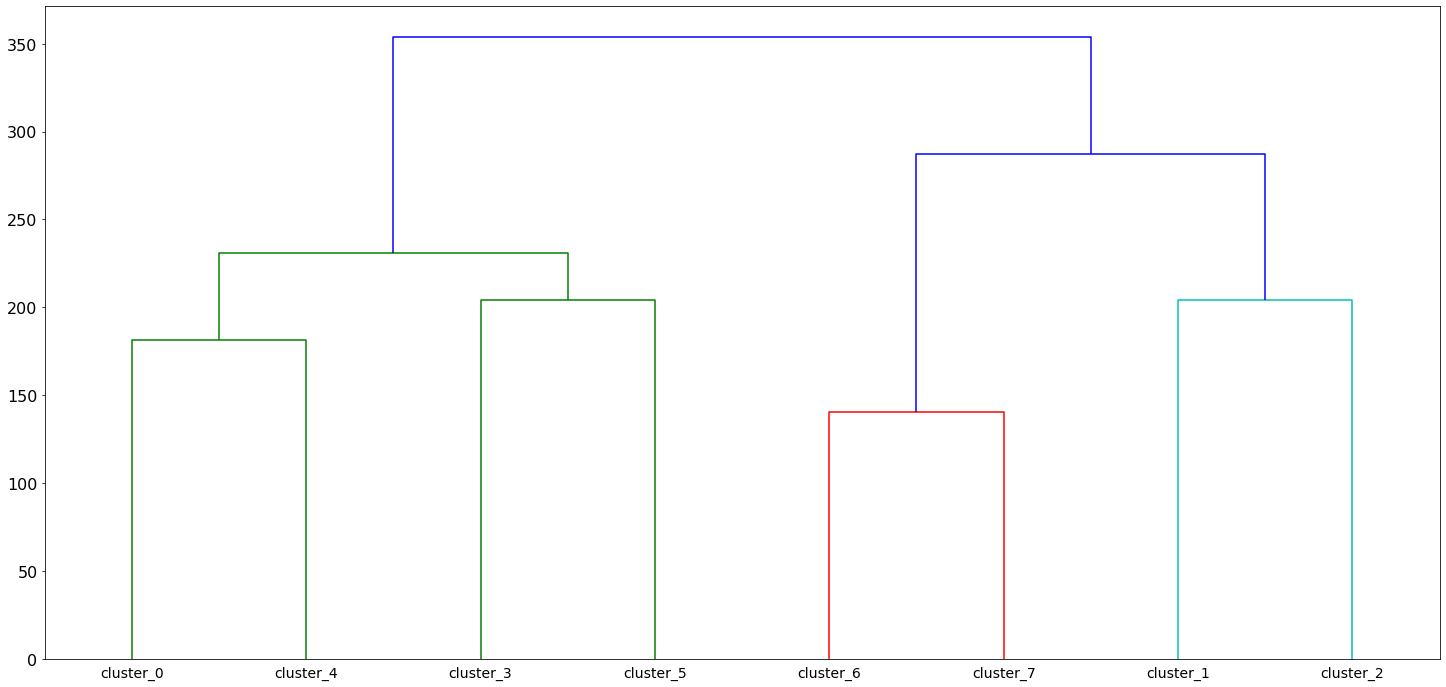

In [96]:
spagat_manager.grouping(dimension_description='space')

### Spatial Aggregation (Representation)

In [97]:
spagat_manager.aggregation_function_dict = {'operationRateMax': ('mean', None), # ('weighted mean', 'capacityMax')
                                            'operationRateFix': ('sum', None),
                                            'locationalEligibility': ('bool', None),
                                            'capacityMax': ('sum', None),
                                            'investPerCapacity': ('sum', None), # ?
                                            'investIfBuilt': ('sum', None), # ? 
                                            'opexPerOperation': ('sum', None), # ?
                                            'opexPerCapacity': ('sum', None), # ?
                                            'opexIfBuilt': ('sum', None), # ?
                                            'interestRate': ('mean', None), # ?
                                            'economicLifetime': ('mean', None), # ?
                                            'capacityFix': ('sum', None),
                                            'losses': ('mean', None), # ?
                                            'distances': ('mean', None), # weighted mean ?
                                            'commodityCost': ('mean', None), # ?
                                            'commodityRevenue': ('mean', None), # ?
                                            'opexPerChargeOperation': ('mean', None),
                                            'opexPerDischargeOperation': ('mean', None),
                                           }

In [98]:
spagat_manager.representation(number_of_regions=n_regions)

/home/r-beer/.conda/envs/spagat_py36/lib/python3.6/site-packages/xarray/core/nanops.py:140: RuntimeWarning: Mean of empty slice
  return np.nanmean(a, axis=axis, dtype=dtype)


In [99]:
spagat_manager.sds_out.xr_dataset.operationRateMax.sum()

<xarray.DataArray 'operationRateMax' ()>
array(35998.10341015)

In [100]:
spagat_manager.sds.xr_dataset.operationRateMax.sum()

<xarray.DataArray 'operationRateMax' ()>
array(103864.23867713)

### Export data back to esM instance

In [101]:
# TODO: hand aggregated data back to eSM

In [102]:
import FINE.IOManagement.dictIO as dictio

In [184]:
esmDict, compDict = dictio.exportToDict(esM)

In [185]:
esmDict, compDict = xrio.update_dicts_based_on_xarray_dataset(esmDict, compDict, xarray_dataset=spagat_manager.sds_out.xr_dataset)

'operationRateFix' for 'Source, Existing run-of-river plants' not in xarray_dataset
'operationRateFix' for 'Sink, Electricity demand' not in xarray_dataset
'operationRateFix' for 'Sink, Hydrogen demand' not in xarray_dataset


In [186]:
esM_aggregated = dictio.importFromDict(esmDict, compDict)

ValueError: Location indices do not match the one of the specified energy system model.
Data indices: {'cluster_6', 'cluster_2', 'cluster_7', 'cluster_5', 'cluster_3', 'cluster_0', 'cluster_4', 'cluster_1'}
Energy system model regions: {'cluster_6_cluster_7', 'cluster_1_cluster_2', 'cluster_0_cluster_4_cluster_3_cluster_5'}

In [ ]:
# TODO: save shapefiles

All components are now added to the model and the model can be optimized. If the computational complexity of the optimization should be reduced, the time series data of the specified components can be clustered before the optimization and the parameter timeSeriesAggregation is set to True in the optimize call.

### Temporal aggregation

In [50]:
esM.cluster(numberOfTypicalPeriods=7)


Clustering time series data with 7 typical periods and 24 time steps per period...
		(4.4242 sec)



/home/r-beer/.conda/envs/spagat_py36/lib/python3.6/site-packages/tsam/timeseriesaggregation.py:960: UserWarning: Something went wrong: At least one maximal value of the aggregated time series exceeds the maximal value the input time series
  "Something went wrong: At least one maximal value of the aggregated time series exceeds the maximal value the input time series")


### Optimization

In [51]:
esM.optimize(timeSeriesAggregation=True, optimizationSpecs='OptimalityTol=1e-3 method=2 cuts=0')

Time series aggregation specifications:
Number of typical periods:7, number of time steps per periods:24

Declaring sets, variables and constraints for SourceSinkModel
	declaring sets... 
	declaring variables... 
	declaring constraints... 
		(0.3894 sec)

Declaring sets, variables and constraints for ConversionModel
	declaring sets... 
	declaring variables... 
	declaring constraints... 
		(0.3488 sec)

Declaring sets, variables and constraints for StorageModel
	declaring sets... 
	declaring variables... 
	declaring constraints... 
		(1.9745 sec)

Declaring sets, variables and constraints for TransmissionModel
	declaring sets... 
	declaring variables... 
	declaring constraints... 
		(0.2610 sec)

Declaring shared potential constraint...
		(0.0017 sec)

Declaring commodity balances...
		(0.9012 sec)

Declaring objective function...
		(0.2830 sec)

Read LP format model from file /tmp/tmpxsd5ovj9.pyomo.lp
Reading time = 0.16 seconds
x53708: 82683 rows, 53708 columns, 251700 nonzeros
Change

for SourceSinkModel ...    (0.9614sec)
for ConversionModel ...    (0.6913sec)
for StorageModel ...       (2.0991sec)
for TransmissionModel ...  (1.9107sec)
		(5.6630 sec)



# 9. Selected results output

Plot locations (GeoPandas required)

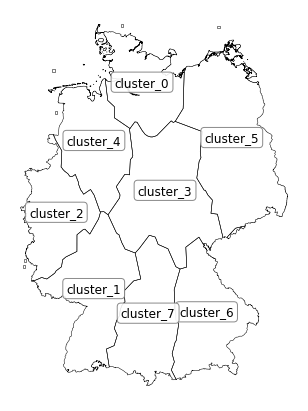

In [52]:
locFilePath = os.path.join(cwd, 'InputData', 'SpatialData','ShapeFiles', 'clusteredRegions.shp')
fig, ax = fn.plotLocations(locFilePath, plotLocNames=True, indexColumn='index')

### Sources and Sink

Show optimization summary

In [53]:
esM.getOptimizationSummary("SourceSinkModel", outputLevel=2)

cluster_0  \
Component                    Property    Unit                                
Biogas purchase              TAC         [1e9 Euro/a]             0.450598   
                             commodCosts [1e9 Euro/a]             0.450598   
                             operation   [GW$_{biogas,LHV}$*h/a]   8330.51   
Electricity demand           operation   [GW$_{el}$*h/a]           30957.9   
Existing run-of-river plants TAC         [1e9 Euro/a]                    0   
                             capacity    [GW$_{el}$]                   NaN   
                             operation   [GW$_{el}$*h/a]               NaN   
                             opexCap     [1e9 Euro/a]                  NaN   
Hydrogen demand              operation   [GW$_{H_{2},LHV}$*h/a]    4765.07   
PV                           TAC         [1e9 Euro/a]              1.32784   
                             capacity    [GW$_{el}$]               17.9701   
                             capexCap    [1e9 Euro/a]              1.09422   
                             invest      [1e9 Euro]                11.6806   
                             operation   [GW$_{el}$*h/a]           11106.9   
                             opexCap     [1e9 Euro/a]             0.233612   
Wind (offshore)              TAC         [1e9 Euro/a]              4.51415   
                             capacity    [GW$_{el}$]                16.107   
                             capexCap    [1e9 Euro/a]              3.77323   
                             invest      [1e9 Euro]                37.0461   
                             operation   [GW$_{el}$*h/a]             52073   
                             opexCap     [1e9 Euro/a]             0.740923   
Wind (onshore)               TAC         [1e9 Euro/a]              7.79686   
                             capacity    [GW$_{el}$]               58.1693   
                             capexCap    [1e9 Euro/a]              6.51714   
                             invest      [1e9 Euro]                63.9862   
                             operation   [GW$_{el}$*h/a]            107522   
                             opexCap     [1e9 Euro/a]              1.27972   

                                                                 cluster_1  \
Component                    Property    Unit                                
Biogas purchase              TAC         [1e9 Euro/a]             0.407035   
                             commodCosts [1e9 Euro/a]             0.407035   
                             operation   [GW$_{biogas,LHV}$*h/a]   7525.14   
Electricity demand           operation   [GW$_{el}$*h/a]            111621   
Existing run-of-river plants TAC         [1e9 Euro/a]             0.113235   
                             capacity    [GW$_{el}$]              0.544397   
                             operation   [GW$_{el}$*h/a]           2668.85   
                             opexCap     [1e9 Euro/a]             0.113235   
Hydrogen demand              operation   [GW$_{H_{2},LHV}$*h/a]    13481.3   
PV                           TAC         [1e9 Euro/a]              1.90692   
                             capacity    [GW$_{el}$]               25.8072   
                             capexCap    [1e9 Euro/a]              1.57143   
                             invest      [1e9 Euro]                16.7747   
                             operation   [GW$_{el}$*h/a]           24050.7   
                             opexCap     [1e9 Euro/a]             0.335494   
Wind (offshore)              TAC         [1e9 Euro/a]                    0   
                             capacity    [GW$_{el}$]                   NaN   
                             capexCap    [1e9 Euro/a]                  NaN   
                             invest      [1e9 Euro]                    NaN   
                             operation   [GW$_{el}$*h/a]               NaN   
                             opexCap     [1e9 Euro/a]                  NaN   
Wind (on

Plot installed capacities

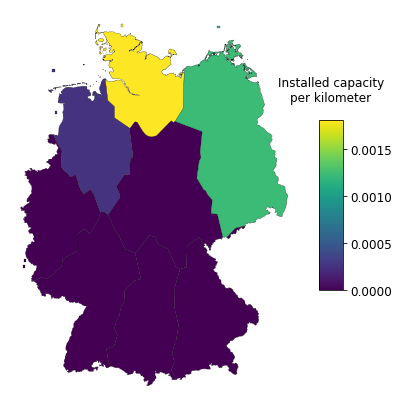

In [59]:
fig, ax = fn.plotLocationalColorMap(esM, 'Wind (onshore)', locFilePath, 'index', perArea=True)

Plot operation time series (either one or two dimensional)

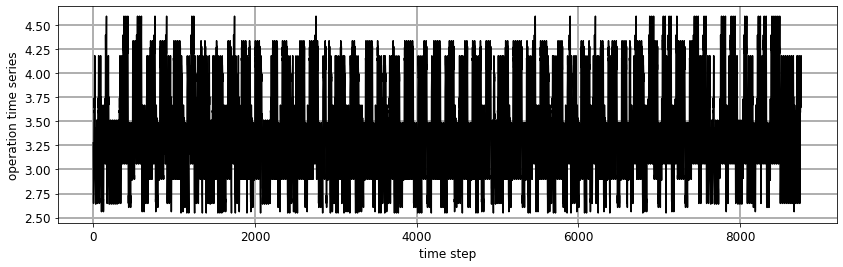

In [56]:
fig, ax = fn.plotOperation(esM, 'Electricity demand', 'cluster_0')

In [ ]:
fig, ax = fn.plotOperationColorMap(esM, 'Electricity demand', 'cluster_0')

### Conversion

Show optimization summary

In [ ]:
esM.getOptimizationSummary("ConversionModel", outputLevel=2)

In [ ]:
fig, ax = fn.plotOperationColorMap(esM, 'New CCGT plants (biogas)', 'cluster_2')

### Storage

Show optimization summary

In [ ]:
esM.getOptimizationSummary("StorageModel", outputLevel=2)

In [ ]:
fig, ax = fn.plotOperationColorMap(esM, 'Li-ion batteries', 'cluster_2', 
                                   variableName='stateOfChargeOperationVariablesOptimum')

In [ ]:
fig, ax = fn.plotOperationColorMap(esM, 'Pumped hydro storage', 'cluster_2',
                                  variableName='stateOfChargeOperationVariablesOptimum')

In [ ]:
fig, ax = fn.plotOperationColorMap(esM, 'Salt caverns (biogas)', 'cluster_2',
                                  variableName='stateOfChargeOperationVariablesOptimum')

In [ ]:
fig, ax = fn.plotOperationColorMap(esM, 'Salt caverns (hydrogen)', 'cluster_2',
                                  variableName='stateOfChargeOperationVariablesOptimum')

## Transmission

Show optimization summary

In [47]:
esM.getOptimizationSummary("TransmissionModel", outputLevel=2).loc['Pipelines (hydrogen)']

AttributeError: 'NoneType' object has no attribute 'dropna'

Check that the shared capacity of the pipelines are not exceeded

In [48]:
df=esM.componentModelingDict["TransmissionModel"].capacityVariablesOptimum
df.loc['Pipelines (biogas)']+df.loc['Pipelines (hydrogen)']

AttributeError: 'NoneType' object has no attribute 'loc'

Plot installed transmission capacities

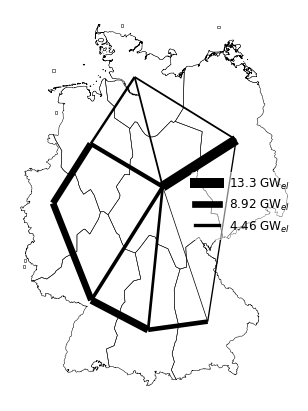

In [60]:
transFilePath = os.path.join(cwd, 'InputData', 'SpatialData','ShapeFiles', 'AClines.shp')

fig, ax = fn.plotLocations(locFilePath, indexColumn='index')                                 
fig, ax = fn.plotTransmission(esM, 'AC cables', transFilePath, loc0='bus0', loc1='bus1', fig=fig, ax=ax)

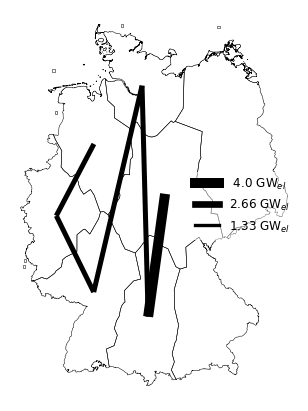

In [61]:
transFilePath = os.path.join(cwd, 'InputData', 'SpatialData','ShapeFiles', 'DClines.shp')

fig, ax = fn.plotLocations(locFilePath, indexColumn='index')                                 
fig, ax = fn.plotTransmission(esM, 'DC cables', transFilePath, loc0='cluster0', loc1='cluster1', fig=fig, ax=ax)

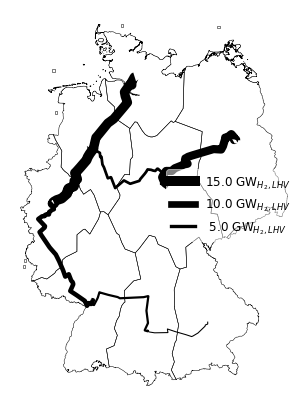

In [62]:
transFilePath = os.path.join(cwd, 'InputData', 'SpatialData','ShapeFiles', 'transmissionPipeline.shp')

fig, ax = fn.plotLocations(locFilePath, indexColumn='index')                                 
fig, ax = fn.plotTransmission(esM, 'Pipelines (hydrogen)', transFilePath, loc0='cluster0', loc1='cluster1',
                              fig=fig, ax=ax)

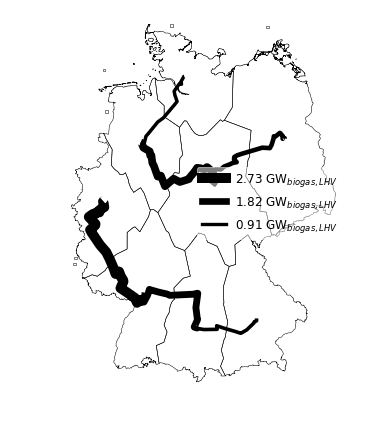

In [50]:
transFilePath = os.path.join(cwd, 'InputData', 'SpatialData','ShapeFiles', 'transmissionPipeline.shp')

fig, ax = fn.plotLocations(locFilePath, indexColumn='index')                                 
fig, ax = fn.plotTransmission(esM, 'Pipelines (biogas)', transFilePath, loc0='cluster0', loc1='cluster1',
                              fig=fig, ax=ax)